In [1]:
import sys
print(sys.version)

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [16]:
%pip install tensorflow
%pip install opencv-python
%pip install scikit-learn



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
!pip install mat73
!pip install tqdm



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 1.5 MB/s eta 0:00:00a 0:00:01


In [12]:
import os
import urllib.request
from tqdm import tqdm

url = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
filename = 'nyu_depth_v2_labeled.mat'
save_directory = os.path.expanduser("~")  # Store in the home directory

# Check if the file already exists in the save directory
if not os.path.exists(os.path.join(save_directory, filename)):
    # Get the file size
    file_size = int(urllib.request.urlopen(url).info().get('Content-Length', -1))

    # Download the file with progress bar
    with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=filename, total=file_size) as pbar:
        urllib.request.urlretrieve(url, os.path.join(save_directory, filename), reporthook=lambda blocks, block_size, total_size: pbar.update(block_size))
else:
    print(f"File '{filename}' already exists in the save directory.")


nyu_depth_v2_labeled.mat: 2.77GB [06:00, 8.24MB/s]                               


In [13]:
import numpy as np
import h5py
import os

# Specify the path to the .mat file in the Ubuntu home directory
file_path = os.path.expanduser("~/nyu_depth_v2_labeled.mat")

# Load the data from the .mat file using h5py
with h5py.File(file_path, 'r') as f:
    X = np.array(f['images'])
    y = np.array(f['depths'])

# Transpose the dimensions of X
X = X.transpose((0, 2, 3, 1))

# Save the training data as NumPy arrays
np.save('nyudepth_v2_x_train.npy', X)
np.save('nyudepth_v2_y_train.npy', y)


X.shape,y.shape

((1449, 640, 480, 3), (1449, 640, 480))

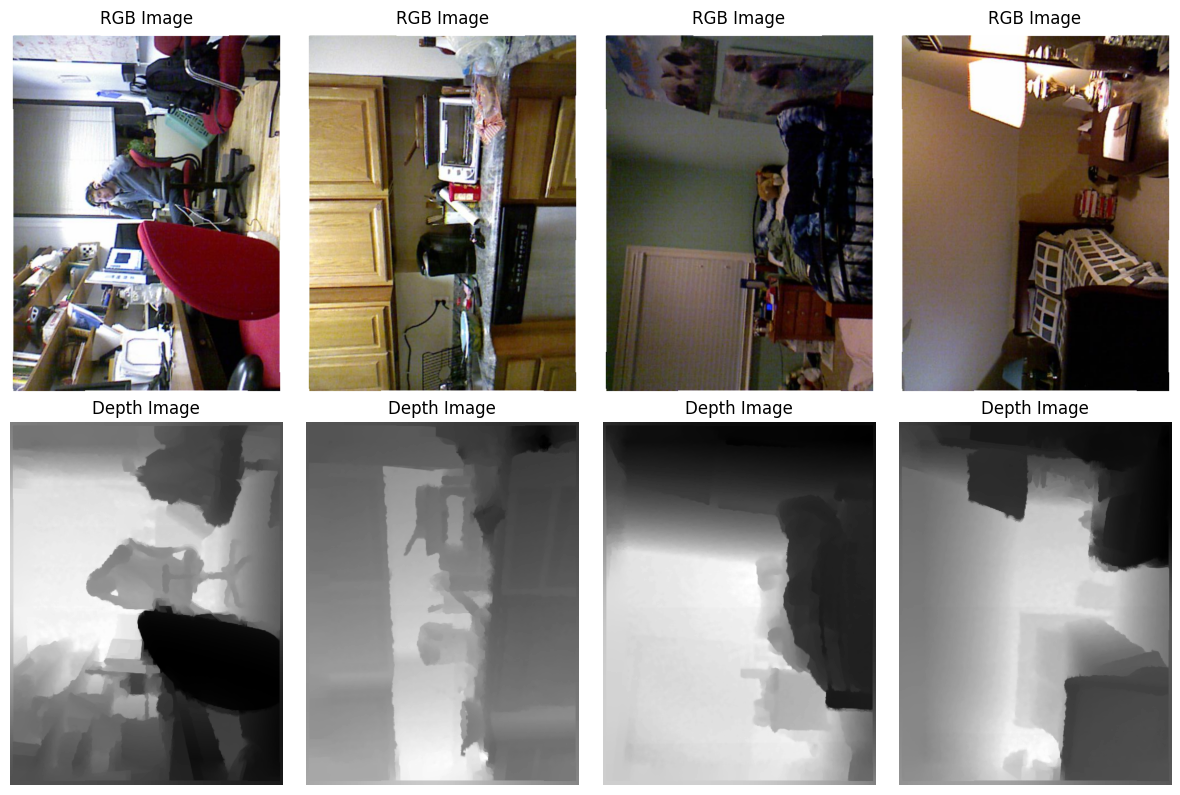

In [14]:
import matplotlib.pyplot as plt

# Display random images from X with corresponding depth images from y
num_images = 4
random_indices = np.random.choice(X.shape[0], num_images, replace=False)

plt.figure(figsize=(12, 8))
for i, index in enumerate(random_indices):
    # Display RGB image
    plt.subplot(2, num_images, i + 1)
    rgb_image = X[index]
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title('RGB Image')

    # Display Depth image
    plt.subplot(2, num_images, num_images + i + 1)
    depth_image = y[index]
    plt.imshow(depth_image, cmap='gray')
    plt.axis('off')
    plt.title('Depth Image')

plt.tight_layout()
plt.show()


In [15]:
import cv2
import numpy as np

# Reshape X and y to the desired shape
X_resized = np.zeros((X.shape[0], 320, 160, 3))
y_resized = np.zeros((y.shape[0], 320, 160))

for i in range(X.shape[0]):
    X_resized[i] = cv2.resize(X[i], (160, 320))
    y_resized[i] = cv2.resize(y[i], (160, 320))

    
X_resized.shape,y_resized.shape

((1449, 320, 160, 3), (1449, 320, 160))

## Doing Train Test Split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resized, y_resized, test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)


(1159, 320, 160, 3) (1159, 320, 160)
(290, 320, 160, 3) (290, 320, 160)


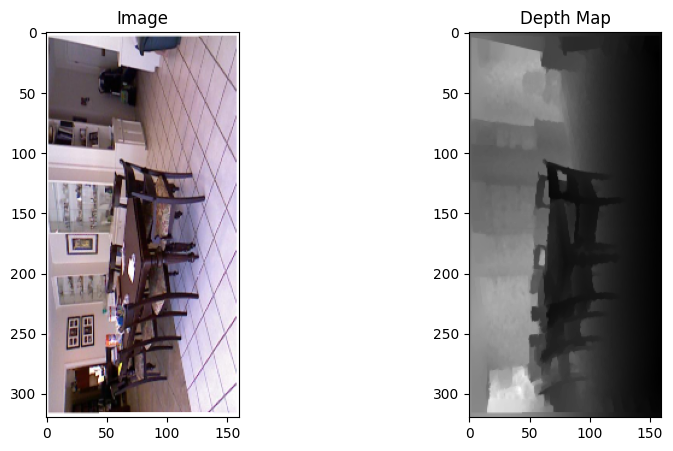

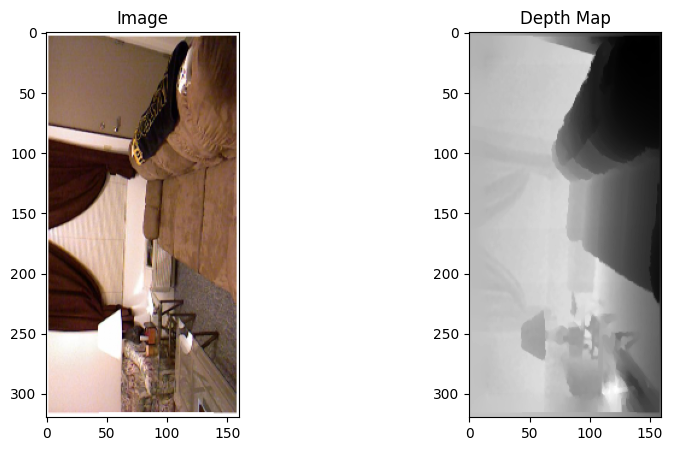

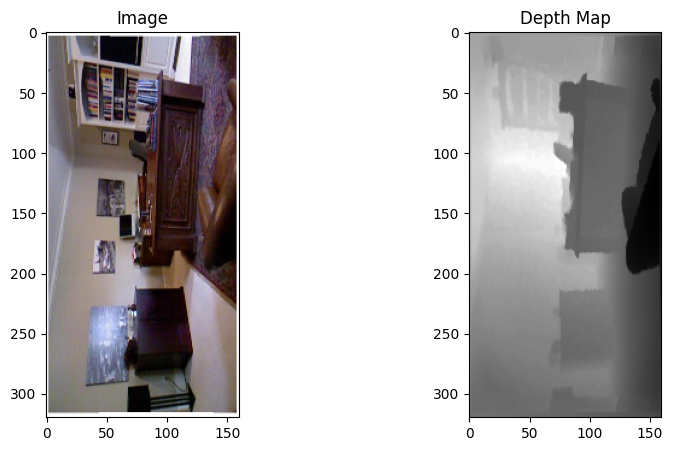

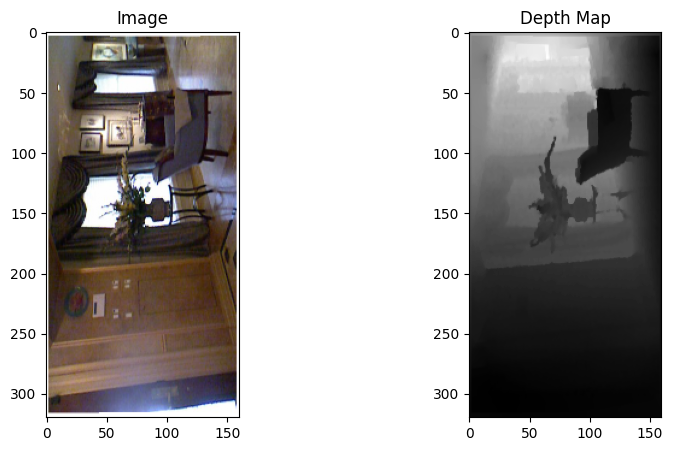

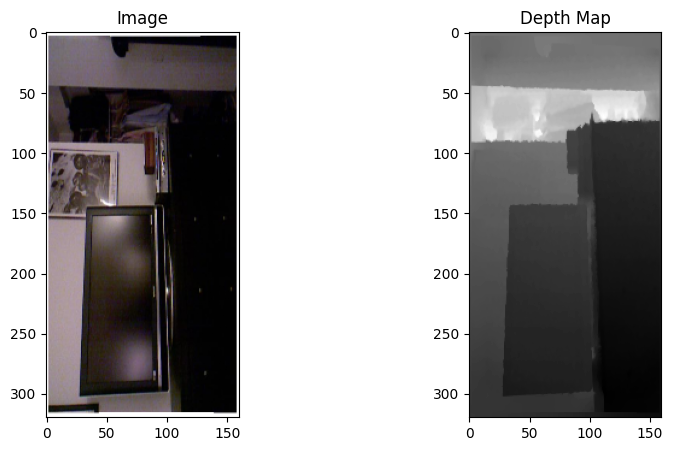

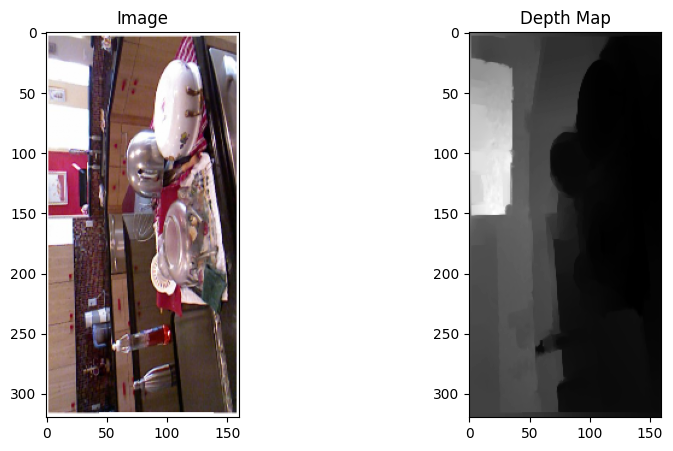

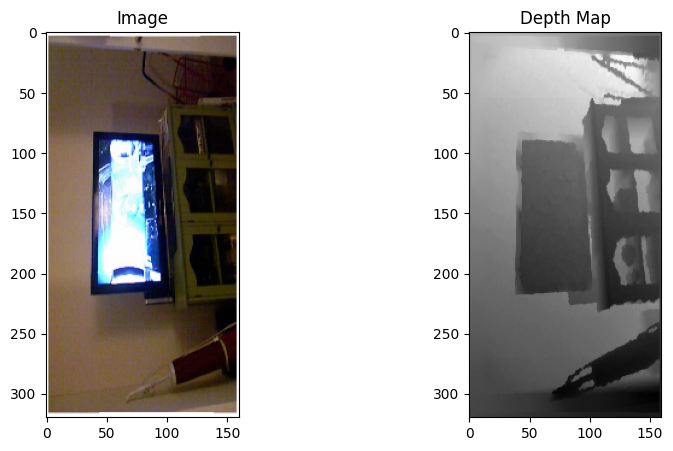

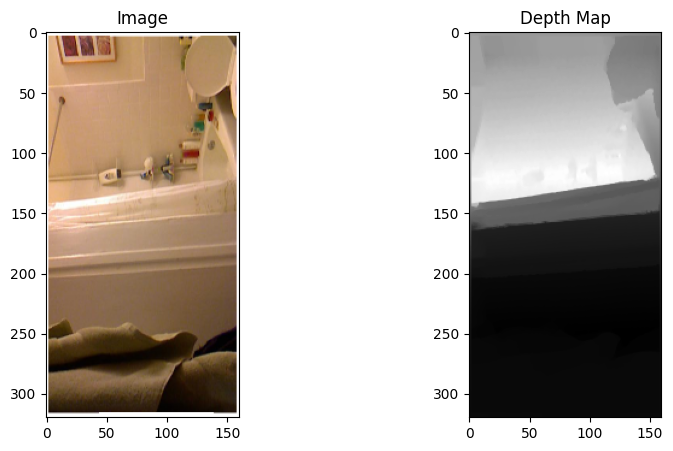

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# define a function to visualize an image with its corresponding depth map
def visualize_image_and_depth_map(X, y):
    # choose a random index
    idx = np.random.randint(X.shape[0])
    # get the image and depth map at that index
    image = X[idx]
    depth_map = y[idx]
    # normalize the pixel values to be between 0 and 1
    image = image / 255.0
    depth_map = depth_map / np.max(depth_map)
    # plot the image and depth map side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(depth_map, cmap='gray')
    ax[1].set_title('Depth Map')
    plt.show()


# visualize 4 random images from X_train
for i in range(4):
    visualize_image_and_depth_map(X_train, y_train)

# visualize 4 random images from X_val
for i in range(4):
    visualize_image_and_depth_map(X_val, y_val)


## Data Visualization and preprocessing

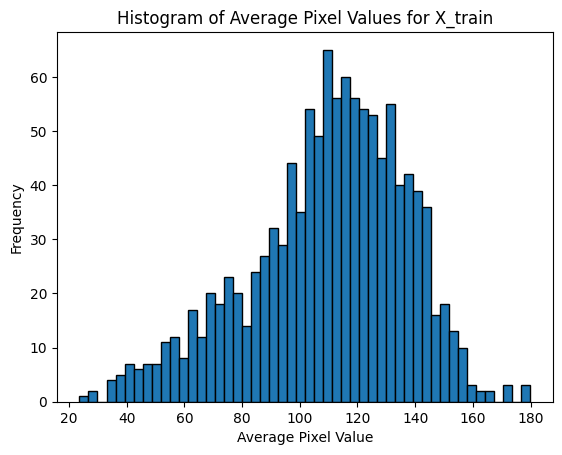

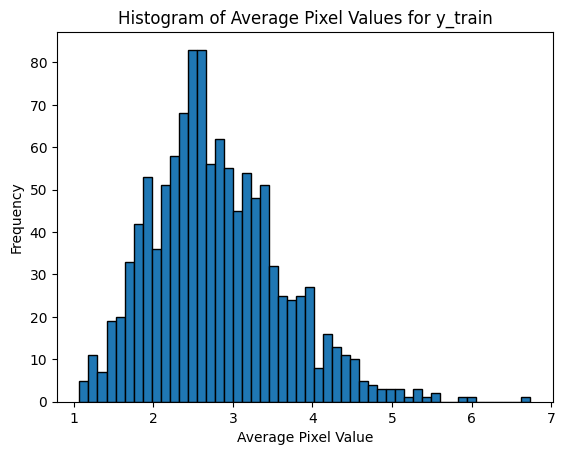

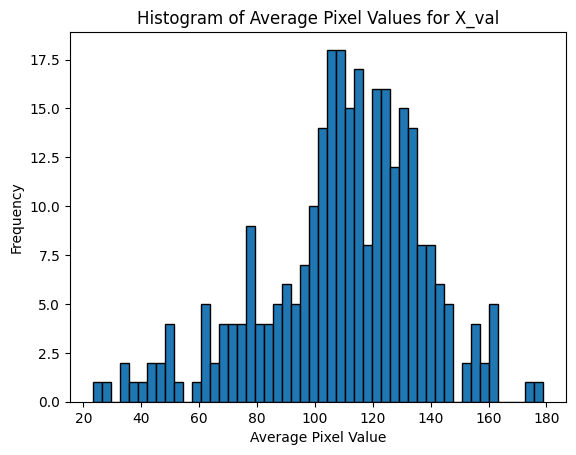

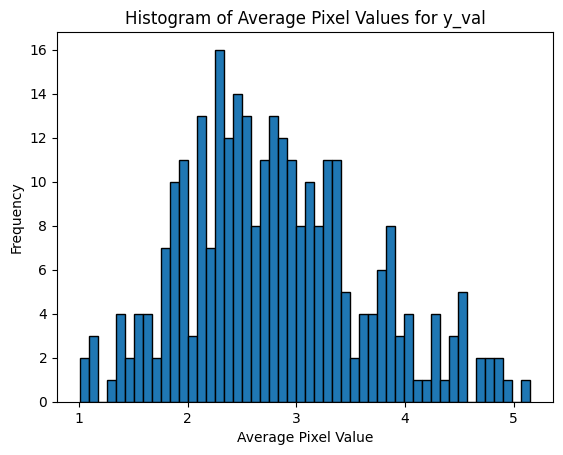

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average pixel values for X_train
avg_pixel_values_X_train = np.mean(X_train, axis=(1, 2, 3))

# Plot the histogram for X_train
plt.hist(avg_pixel_values_X_train, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for X_train')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Calculate the average pixel values for y_train
avg_pixel_values_y_train = np.mean(y_train, axis=(1, 2))


# Plot the histogram for y_train
plt.hist(avg_pixel_values_y_train, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for y_train')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Calculate the average pixel values for X_val
avg_pixel_values_X_val = np.mean(X_val, axis=(1, 2, 3))


# Plot the histogram for X_val
plt.hist(avg_pixel_values_X_val, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for X_val')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Calculate the average pixel values for y_val
avg_pixel_values_y_val = np.mean(y_val, axis=(1, 2))


# Plot the histogram for y_val
plt.hist(avg_pixel_values_y_val, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for y_val')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()


2023-06-14 23:20:13.234130: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


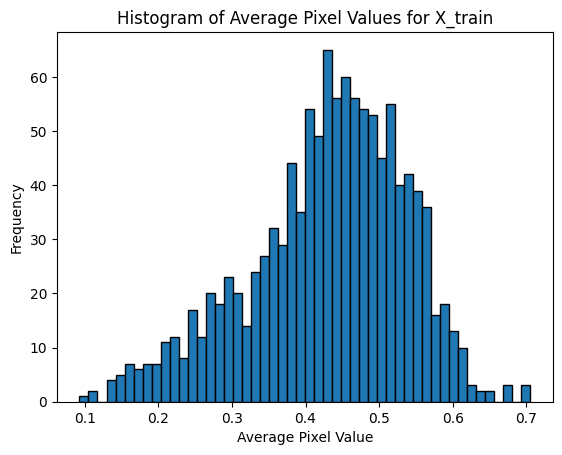

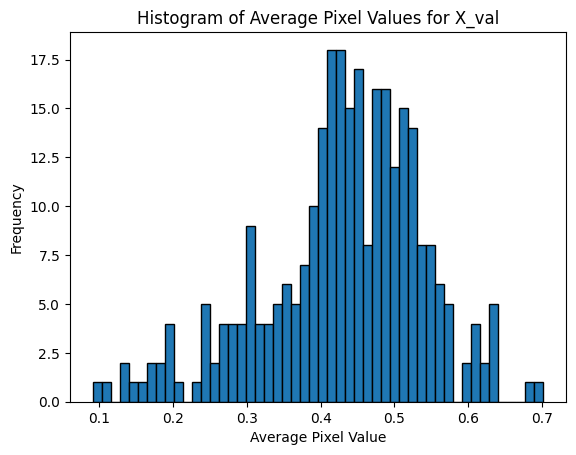

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Preprocess the images
def preprocess_images(images):
    # Normalize the pixel values to the range [0, 1]
    images = images.astype('float32') / 255.0
    
    # Resize the images to a desired shape
    resized_images = tf.image.resize(images, (160,320))
    
    return resized_images

# Preprocess X_train, X_val
X_train_processed = preprocess_images(X_train)
X_val_processed = preprocess_images(X_val)



import numpy as np
import matplotlib.pyplot as plt

# Calculate the average pixel values for X_train
avg_pixel_values_X_train = np.mean(X_train_processed, axis=(1, 2, 3))

# Plot the histogram for X_train
plt.hist(avg_pixel_values_X_train, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for X_train')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()


# Calculate the average pixel values for X_val
avg_pixel_values_X_val = np.mean(X_val_processed, axis=(1, 2, 3))


# Plot the histogram for X_val
plt.hist(avg_pixel_values_X_val, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for X_val')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()




### Now training the Basic Model 
 1. Normal Loss Function Mean Squared Error 
 2. And The model size is also very simple 

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the Transformer model for depth map prediction
class TransformerModel(tf.keras.Model):
    def __init__(self, input_shape):
        super(TransformerModel, self).__init__()

        self.encoder = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", input_shape=input_shape)
        self.transformer = tf.keras.Sequential([
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Reshape((320, 160, 128)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.Conv2D(1, kernel_size=(3, 3), activation="relu", padding="same"),
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.transformer(x)
        x = self.decoder(x)
        return x

# Create an instance of the Transformer model
input_shape = (320, 160, 3)
model = TransformerModel(input_shape)

# Build the model by passing a sample input
sample_input = tf.random.normal((1,) + input_shape)
model(sample_input)

# Print the model summary
model.summary()

# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model and calculate loss with actual depth maps
history=model.fit(X_train_processed, y_train, batch_size=32, epochs=10, validation_data=(X_val_processed, y_val))

# Evaluate the model
loss = model.evaluate(X_val_processed, y_val)
print("Test loss:", loss)

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print("Train loss:", train_loss)
print("Validation loss:", val_loss)

# Generate random indices for visualization
random_indices = np.random.choice(range(len(X_val_processed)), size=5, replace=False)
random_indices = random_indices.astype(int)  # Convert indices to integers

# Generate depth map predictions for the selected indices
predictions = model.predict(X_val_processed.numpy()[random_indices])

# Visualize the results
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val_processed[index])
    plt.title("Actual Image")

    plt.subplot(3, 5, i + 6)
    plt.imshow(y_val[index], cmap='gray')
    plt.title("Actual Depth Map")

    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i], cmap='gray')
    plt.title("Predicted Depth Map")

plt.tight_layout()
plt.show()




Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 sequential (Sequential)     (1, 320, 160, 128)        49536     
                                                                 
 sequential_1 (Sequential)   (1, 320, 160, 1)          74369     
                                                                 
Total params: 125,697
Trainable params: 125,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
37/37 [==============================] - 603s 16s/step - loss: 3.4332 - val_loss: 2.0890
Epoch 2/10
 1/37 [..............................] - ETA: 9:16 - loss: 2.0219

### Now with same model but different Loss function

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Custom loss function for depth map prediction
import tensorflow.keras.backend as K

def custom_depth_loss(y_true, y_pred):
    # Reconstruction loss (L1 loss)
    recon_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Reshape the depth maps for SSIM calculation
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    # Structural similarity index (SSIM) loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    # Additional loss function (e.g., mean squared error)
    mse_loss = K.mean(K.square(y_true - y_pred))

    # Weighted sum of all the losses
    total_loss = 0.6 * recon_loss + 0.2 * ssim_loss + 0.2 * mse_loss

    return total_loss


# Define the Transformer model for depth map prediction
class TransformerModel(tf.keras.Model):
    def __init__(self, input_shape):
        super(TransformerModel, self).__init__()

        self.encoder = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", input_shape=input_shape)
        self.transformer = tf.keras.Sequential([
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Reshape((320, 160, 128)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.Conv2D(1, kernel_size=(3, 3), activation="relu", padding="same"),
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.transformer(x)
        x = self.decoder(x)
        return x

# Create an instance of the Transformer model
input_shape = (320, 160, 3)
model = TransformerModel(input_shape)

# Build the model by passing a sample input
sample_input = tf.random.normal((1,) + input_shape)
model(sample_input)

# Print the model summary
model.summary()

# Compile the model with the custom loss function
model.compile(loss=custom_depth_loss, optimizer="adam")

# Train the model
history = model.fit(X_train_processed, y_train, batch_size=32, epochs=10, validation_data=(X_val_processed, y_val))

# Evaluate the model
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print("Train loss:", train_loss)
print("Validation loss:", val_loss)

# Select 5 random images from the validation set
random_indices = np.random.choice(range(len(X_val_processed)), size=5, replace=False)

# Generate depth map predictions for the selected indices
predictions = model.predict(X_val_processed.numpy()[random_indices])


train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print("Train loss:", train_loss)
print("Validation loss:", val_loss)

# Plot the training and validation loss graphs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Visualize the results
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val_processed[index])
    plt.title("Actual Image")

    plt.subplot(3, 5, i + 6)
    plt.imshow(y_val[index], cmap='gray')
    plt.title("Actual Depth Map")

    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i], cmap='gray')
    plt.title("Predicted Depth Map")

plt.tight_layout()
plt.show()


## Trying another model 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Preprocess the images
def preprocess_images(images):
    # Normalize the pixel values to the range [0, 1]
    images = images.astype('float32') / 255.0
    
    # Resize the images to a desired shape
    resized_images = tf.image.resize(images, (320,160))
    
    return resized_images

# Preprocess X_train, X_val
X_train_processed = preprocess_images(X_train)
X_val_processed = preprocess_images(X_val)



import numpy as np
import matplotlib.pyplot as plt

# Calculate the average pixel values for X_train
avg_pixel_values_X_train = np.mean(X_train_processed, axis=(1, 2, 3))

# Plot the histogram for X_train
plt.hist(avg_pixel_values_X_train, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for X_train')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()


# Calculate the average pixel values for X_val
avg_pixel_values_X_val = np.mean(X_val_processed, axis=(1, 2, 3))


# Plot the histogram for X_val
plt.hist(avg_pixel_values_X_val, bins=50, edgecolor='black')
plt.title('Histogram of Average Pixel Values for X_val')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.show()




##### This is another loss function that i'll use Tommorow for my model

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.models import vgg16

def depth_loss(predicted_depth, ground_truth_depth, alpha=0.85, beta=0.1, gamma=0.05, delta=1.0):
    # Mean Squared Error (MSE) loss
    mse_loss = F.mse_loss(predicted_depth, ground_truth_depth)

    # Huber loss
    residual = torch.abs(predicted_depth - ground_truth_depth)
    huber_loss = torch.where(residual <= delta, 0.5 * residual ** 2, delta * residual - 0.5 * delta ** 2)
    huber_loss = torch.mean(huber_loss)

    # Structural Similarity Index (SSIM) loss
    ssim_loss = 1 - torch.mean(torch.functional.image.ssim(predicted_depth, ground_truth_depth, data_range=1, size_average=True))

    # Depth smoothness loss
    grad_x = torch.abs(predicted_depth[:, :, :, :-1] - predicted_depth[:, :, :, 1:])
    grad_y = torch.abs(predicted_depth[:, :, :-1, :] - predicted_depth[:, :, 1:, :])
    smoothness_loss = torch.mean(grad_x) + torch.mean(grad_y)

    # Perceptual loss using VGG features
    vgg = vgg16(pretrained=True).features[:23].eval().to(predicted_depth.device)
    vgg_predicted = vgg(predicted_depth)
    vgg_ground_truth = vgg(ground_truth_depth)
    perceptual_loss = F.mse_loss(vgg_predicted, vgg_ground_truth)

    # Combined loss
    total_loss = alpha * mse_loss + beta * huber_loss + gamma * ssim_loss + delta * smoothness_loss + perceptual_loss

    return total_loss


### This is relatively Advance Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Custom loss function for depth map prediction
import tensorflow.keras.backend as K

def custom_depth_loss(y_true, y_pred):
    # Reconstruction loss (L1 loss)
    recon_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Reshape the depth maps for SSIM calculation
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    # Structural similarity index (SSIM) loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    # Additional loss function (e.g., mean squared error)
    mse_loss = K.mean(K.square(y_true - y_pred))

    # Weighted sum of all the losses
    total_loss = 0.6 * recon_loss + 0.2 * ssim_loss + 0.2 * mse_loss

    return total_loss


# Define the Transformer model for depth map prediction
class TransformerModel(tf.keras.Model):
    def __init__(self, input_shape):
        super(TransformerModel, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", input_shape=input_shape),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        ])
        self.transformer = tf.keras.Sequential([
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Reshape((input_shape[0], input_shape[1], 256)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.Conv2D(1, kernel_size=(3, 3), activation="relu", padding="same"),
        ])

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.transformer(x)
        x = self.decoder(x)
        return x


# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('GPU is available.')
    try:
        # Enable memory growth for the GPU device
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Create an instance of the Transformer model
input_shape = (320, 160, 3)
model = TransformerModel(input_shape)

# Build the model by passing a sample input
sample_input = tf.random.normal((1,) + input_shape)
model(sample_input)

# Print the model summary
model.summary()

# Compile the model with the custom loss function
model.compile(loss=custom_depth_loss, optimizer="adam")

# Train the model using GPU acceleration
with tf.device('/GPU:0'):
    history = model.fit(X_train_processed, y_train, batch_size=32, epochs=10, validation_data=(X_val_processed, y_val))

# Evaluate the model
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print("Train loss:", train_loss)
print("Validation loss:", val_loss)

# Plot the training and validation loss graphs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Select 5 random images from the validation set
random_indices = np.random.randint(0, len(X_val_processed), size=5)

# Generate depth map predictions for the selected indices
predictions = model.predict(X_val_processed.numpy()[random_indices])

# Visualize the results
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val_processed[index])
    plt.title("Actual Image")

    plt.subplot(3, 5, i + 6)
    plt.imshow(y_val[index], cmap='gray')
    plt.title("Actual Depth Map")

    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i], cmap='gray')
    plt.title("Predicted Depth Map")

plt.tight_layout()
plt.show()


### Most advance Model 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Concatenate, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Custom loss function for depth map prediction
def custom_depth_loss(y_true, y_pred):
    # Reconstruction loss (L1 loss)
    recon_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Reshape the depth maps for SSIM calculation
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    # Structural similarity index (SSIM) loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    # Weighted sum of the reconstruction and SSIM losses
    total_loss = 0.85 * recon_loss + 0.15 * ssim_loss

    return total_loss


# Define the encoder-decoder model with skip connections
def encoder_decoder_model(input_shape):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    skip_connections = []

    for filters in [64, 128, 256]:
        # Residual block
        for _ in range(2):
            x = Conv2D(filters, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        skip_connections.append(x)
        x = MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    for filters, skip_connection in zip(reversed([64, 128, 256]), reversed(skip_connections)):
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, skip_connection])
        for _ in range(2):
            x = Conv2D(filters, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    # Output
    output = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

    model = Model(inputs=inputs, outputs=output)
    return model


# Create the model
model = encoder_decoder_model(input_shape=X_train_processed.shape[1:])

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_depth_loss)

# Train the model
history = model.fit(X_train_processed, y_train, batch_size=32, epochs=15, validation_data=(X_val_processed, y_val))

# Plot the training and validation loss for each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Select 5 random images from the validation set
random_indices = np.random.choice(range(len(X_val_processed)), size=5, replace=False)

# Generate depth map predictions for the selected indices
predictions = model.predict(X_val_processed.numpy()[random_indices])

# Visualize the results
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val_processed[index])
    plt.title("Actual Image")

    plt.subplot(3, 5, i + 6)
    plt.imshow(y_val[index], cmap='gray')
    plt.title("Actual Depth Map")

    plt.subplot(3, 5, i + 11)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Depth Map")

plt.tight_layout()
plt.show()
